# 심화과제 - 논문 요약 LLM 서비스

논문 요약 LLM 서비스는 다음과 같이 구성됩니다:

- **입력:** 논문 요약 서비스는 논문 pdf 하나와 요약을 위한 prompting을 입력으로 받습니다. 논문과 prompt는 다음과 같이 정하시면 됩니다:
    - 논문: https://arxiv.org/pdf/2005.11401
    - Prompt: 주어진 논문을 요약하기 위해 어떻게 prompt를 구성해야할지 여러분들이 결정하셔야 합니다.
- **방법론:** LLM은 `gpt-4o-mini`, 그리고 PDF를 처리하기 위한 RAG를 활용하셔야 합니다.
- **출력:** 별다른 가공 없이 LLM의 답변을 그대로 출력하시면 됩니다.

위의 LLM 서비스를 다음 요구사항을 충족시키며 개발하시면 됩니다:

- [x]  논문 PDF를 `docs`로 변환
    - 이전 RAG 실습에서는 LangChain의 `WebBaseLoader`를 활용하여 주어진 인터넷 사이트를 `docs`로 변환했습니다.
    - 이번 과제에서는 인터넷 사이트가 아닌 PDF 파일이 주어지기 때문에, 다른 형태의 loader를 활용하여 PDF를 처리하셔야 합니다.
- [x]  논문 요약 prompting 제안
    - LLM에 RAG 처리 된 PDF와 함께 입력으로 줄 prompt를 구성하셔야 합니다.
- [x]  주어진 논문에 대한 요약

## 1. 필요한 라이브러리 설치 및 import

In [22]:
!pip install langchain-community langchain-chroma langchain-openai unstructured unstructured-inference pytesseract unstructured-pytesseract pi_heif pdf2image rouge-score evaluate pdfplumber bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


In [2]:
!apt-get update -qq
!apt-get install -y poppler-utils tesseract-ocr

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.7).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.


In [3]:
# OCR 에이전트 환경변수 설정
%env OCR_AGENT=unstructured.partition.utils.ocr_models.tesseract_ocr.OCRAgentTesseract

env: OCR_AGENT=unstructured.partition.utils.ocr_models.tesseract_ocr.OCRAgentTesseract


In [4]:
from langchain import hub
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document
import getpass
import requests
from langchain_community.document_loaders import UnstructuredPDFLoader

## 2. llm 모델 정의

In [5]:
api_key = getpass.getpass('Enter your API key: ')
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

Enter your API key: ··········


## 3. PDF 다운로드 및 추출

In [6]:
import requests

def download_pdf(url: str, target_path: str):
    resp = requests.get(url)
    resp.raise_for_status()
    with open(target_path, 'wb') as f:
        f.write(resp.content)

# 사용 예
pdf_url = "https://arxiv.org/pdf/2005.11401"
download_pdf(pdf_url, "example.pdf")


In [7]:
from langchain.document_loaders import UnstructuredPDFLoader

loader = UnstructuredPDFLoader("./example.pdf")
docs = loader.load()  # page 단위로 Document(list of dict) 반환
# docs[i].page_content 에 텍스트가 들어 있어요


 * LangChain의 UnstructuredPDFLoader
  * 형식이 없는 PDF 문서 로드할 때 사용함

In [8]:
# 추출한 내용 확인
docs
# docs[0].page_content[:1000]

[Document(metadata={'source': './example.pdf'}, page_content='2005.11401v4 [cs.CL] 12 Apr 2021\n\narXiv\n\nRetrieval-Augmented Generation for Knowledge-Intensive NLP Tasks\n\nPatrick Lewis\'t, Ethan Perez*, Aleksandra Piktus\', Fabio Petroni\', Viadimir Karpukhin\', Naman Goyal’, Heinrich Kiittler\', Mike Lewis‘, Wen-tau Yih‘, Tim Rocktischel\'?, Sebastian Riedel\'t, Douwe Kiela*\n\n+Racebook AI Research; *University College London; *New York University; plewis@fb.com\n\nAbstract\n\nLarge pre-trained language models have been shown to store factual knowledge in their parameters, and achieve state-of-the-art results when fine-tuned on down- stream NLP tasks. However, their ability to access and precisely manipulate knowl- edge is still limited, and hence on knowledge-intensive tasks, their performance lags behind task-specific architectures. Additionally, providing provenance for their decisions and updating their world knowledge remain open research problems. Pre- trained models with a

## 4. RAG 파이프라인 구축하기

### 텍스트 청크화 -> 벡터화 -> 저장

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200
)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings(api_key=api_key)
)

* **RecursiveCharacterTextSplitter**
  * 긴 텍스트를 문단("\n\n"), 문장("\n"), 단어(" ") 단위로 재귀적으로 쪼갬
  * 지정한 `chunk_size` 이하 크기의 청크로 분할해주는 도구
  * 의미 단위가 최대한 보존 된 채로 텍스트를 나눌 수 있다..?
  * chunk_size(int): 한 청크의 최대 문자 수
  * chunk_overlap(int) : 연속된 청크 사이에 겹치게 포함할 문자 수. 문맥 연속성을 조금씩 중복시켜 놓으면 RAG 시 검색 정확도가 올라감..

* **split_documents**
  * 주어진 문서를 내부적으로 `page_content` 기준으로 자른다.
  * `chunk_size`와 `chunk_overlap`에 맞춘 새로운 청크 문서 리스트로 반환함
  * 메타데이터는 원본에서 복사되어 유지됨

* **Chroma.from_documents**
  * `documents`의 각 청크 텍스트를 `embedding` 함수로 임베딩 벡터로 변환
  * Chroma DB에 저장하여 벡터 검색이 가능하도록 벡터 저장소를 초기화
  
    => `similarity_search()` 같은 메서드로 청크를 빠르게 찾아올 수 있음

In [10]:
print(splits)


[Document(metadata={'source': './example.pdf'}, page_content="2005.11401v4 [cs.CL] 12 Apr 2021\n\narXiv\n\nRetrieval-Augmented Generation for Knowledge-Intensive NLP Tasks\n\nPatrick Lewis't, Ethan Perez*, Aleksandra Piktus', Fabio Petroni', Viadimir Karpukhin', Naman Goyal’, Heinrich Kiittler', Mike Lewis‘, Wen-tau Yih‘, Tim Rocktischel'?, Sebastian Riedel't, Douwe Kiela*\n\n+Racebook AI Research; *University College London; *New York University; plewis@fb.com\n\nAbstract"), Document(metadata={'source': './example.pdf'}, page_content='Large pre-trained language models have been shown to store factual knowledge in their parameters, and achieve state-of-the-art results when fine-tuned on down- stream NLP tasks. However, their ability to access and precisely manipulate knowl- edge is still limited, and hence on knowledge-intensive tasks, their performance lags behind task-specific architectures. Additionally, providing provenance for their decisions and updating their world knowledge rem

In [11]:
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

# 검색기 생성
retriever = vectorstore.as_retriever()


new_system = """\
As an expert of strategic management and entrepreneurship, read this paper and answer the following questions precisely and quantitatively, with all the best of yours. But Jargon can be used as is. You do not have to replace them with easy words. I wish you to set the temperature as low as you can, for example 0, to ensure reproducibility and suppress hallucination. (한국어로 정리를 원하시면, Write in Korean 추가해주세요)

1. What is the purpose of the authors in this research?
2. What are the gaps in the prior literature and what are the originalities of this research? Answer in bulletins.
3. What is the research setting and data authors used? What are the main independent and dependent variables in the paper? What analytical model did they use? List in bulletins and explain briefly.
4. What is the contribution of this paper to academia and the industrial sector?
5. What are the limitations of this research? Answer in bulletins.
6. List the important references in this paper with reason.

   * Column names should be ["citation point", "authors", "title", "journal", "year", "doi"]
   * "Citation point" is the reason why the authors thought these are important.
   * "doi"s should be clickable links, by adding "【https://doi.org/】" in front of dois if needed.

Write in Korean

"""

new_user = """\
Below is an excerpt from a paper retrieved and extracted using RAG:
{context}

Based on the above content, please summarize the following items in Korean:
1. Purpose of the paper
2. Major contributions
3. Methodology used
4. Key results
5. Limitations and future research directions

For each item, you **must** include:
- Relevant metrics and their exact values
- Section and page references (e.g., §4.1, p.5)
- Specific numerical results (e.g., EM = 44.5 %, Bleu-1 = 40.8)

(Use a subheading for each item and answer in 3–5 sentences.)

"""

summary_prompt = ChatPromptTemplate(
    input_variables=["context"],
    messages=[
        SystemMessagePromptTemplate.from_template(new_system),
        HumanMessagePromptTemplate.from_template(new_user),
    ],
)

print(summary_prompt)


input_variables=['context'] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='As an expert of strategic management and entrepreneurship, read this paper and answer the following questions precisely and quantitatively, with all the best of yours. But Jargon can be used as is. You do not have to replace them with easy words. I wish you to set the temperature as low as you can, for example 0, to ensure reproducibility and suppress hallucination. (한국어로 정리를 원하시면, Write in Korean 추가해주세요)\n\n1. What is the purpose of the authors in this research?\n2. What are the gaps in the prior literature and what are the originalities of this research? Answer in bulletins.\n3. What is the research setting and data authors used? What are the main independent and dependent variables in the paper? What analytical model did they use? List in bulletins and explain briefly.\n4. What is the contribut

* `retriever` : 벡터 저장소의 검색기, 조회기
* 어떤 질문이 던져졌을 때, 이 질문과 유사한 임베딩을 가지고 있는 text를 추출함
* 질문 입력 -> 질문 임베딩으로 변환 -> vectorstore에 있는 임베딩들과 비교 -> 비슷하다고 판단되는 임베딩 반환

In [12]:
# RAG를 통해 추출된 text들을 모두 concat함
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


## 랭체인의 chain + LCEL으로 쉽게 구현해보기

In [13]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# 입력 바인딩 -> 프롬프트 invoke → LLM invoke → 파싱
rag_chain = (
    {"context": retriever | format_docs}
    | summary_prompt
    | llm
    | StrOutputParser()
)

`{"context": retriever | format_docs, "question": RunnablePassthrough()}`

`Runnable` : 실행할 수 있는 무언가.. 입력을 받고 처리하고 결과를 내놓는

* 이 dict를 하나의 실행 단위(Runnable)로 본다.
* 사용자의 질문을 받음 -> "context"에 해당하는 작업 실행 -> "question"에 해당하는 작업 실행 -> 그 두 결과를 `{"context": ..., "question":...}` 형태로 묶어서 다음 단계로 넘긴다.

* `"context": retriever | format_docs`
  * `retriever` (=`vectorestore.as_retriever()`)가 먼저 호출돼서 입력 맵에 `question` 값을 꺼내 벡터 검색함
  * `format_docs`가 검색된 `Document`리스트를 포매팅
  * 파이프 (|) : 이전 Runnable 출력 -> 다음 Runnable 입력을 잇는 역할

In [14]:
summary = rag_chain.invoke("")
print(summary)

### 1. 논문의 목적
이 논문의 목적은 RAG( retrieval-augmented generation) 모델을 통해 사실 추출 및 검증을 수행하는 새로운 접근 방식을 제시하는 것이다. 이를 통해 기존의 복잡한 파이프라인 시스템과 비교하여 단순성과 효율성을 강조한다. 특히, RAG는 도메인 특정 아키텍처나 중간 검색 감독 없이도 성능을 발휘할 수 있음을 보여준다.

### 2. 주요 기여
- **성능:** RAG 모델은 3-way 분류에서 최첨단 모델과 비교했을 때 4.3% 내외의 성과를 보였다(§4.4, p.14).
- **단순성:** RAG는 복잡한 시스템 없이도 유효한 결과를 도출할 수 있는 능력을 지닌다.
- **응용 가능성:** 다양한 언어 모델의 기능을 접목하여 사실 기반의 대화형 응용 프로그램 개발에 기여할 수 있다.

### 3. 사용된 방법론
- **데이터셋:** FEVER 데이터셋을 사용하여 모델 성능을 검증한다.
- **모델 검증:** RAG 모델의 성능을 3-way 분류로 평가하며, 복잡한 파이프라인 대비 단순한 구조를 강조한다(§4.4, p.14).
- **정량적 결과:** RAG 모델이 생성한 응답의 사실 정확성은 높은 비율로 유지되며, 특정 입력에 대해 더 정교한 응답을 낸다.

### 4. 주요 결과
- RAG 모델은 3-way 분류에서 정확도가 4.3% 떨어지는 성과를 보였으며, 이는 기존 방법론에 비해 우수한 수치를 나타낸다(§4.4, p.14).
- 생성된 응답의 구체성과 사실 기반 정확성을 높여, 더 나은 대화형 AI의 기반을 마련한다.

### 5. 한계 및 미래 연구 방향
- **한계:** RAG 모델의 데이터 기반이 외부 지식원(예: 위키피디아)의 완전한 사실성을 담보하지 않음으로 인해 생성된 콘텐츠의 신뢰성에 문제가 있을 수 있다(§4.4, p.14).
- **미래 연구 방향:** 다루기 어려운 또는 편향된 내용을 자동으로 생성하지 않도록 개선할 수 있는 AI 시스템의 개발 필요성; 다양한 언어의 지원 범위를 확대

## ROUGE로 평가
* 단어 겹침으로 평가

In [19]:
import pdfplumber

def extract_text_pdfplumber(path: str) -> str:
    texts = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            t = page.extract_text()
            if t:
                texts.append(t)
    return "\n".join(texts)

reference_text = extract_text_pdfplumber("./reference.pdf")

In [20]:
reference_text

'정답 요약\n작성일시 @2025년 4월 24일 오전 10:52\n유형\n논문의 목적\n1.\n이 논문의 목적은 Retrieval-Augmented Generation(RAG) 모델을 제안하고, 이를 다양\n한 지식 집약적 NLP 과제에 적용하여 기존 parametric-only 모델의 한계를 극복하는 것이\n다. 특히 지식 갱신, 설명 가능성, 환각(hallucination) 문제 등을 해결할 수 있는 구조를 제\n시하며, parametric memory(BART)와 non-parametric memory(Wikipedia 기반\nDPR\ue082를 결합한 end-to-end 학습 가능한 프레임워크를 강조한다.\n주요 기여\n2.\n범용성: 다양한 seq2seq 과제에 적용 가능한 RAG 구조 제안\n모델 구조: RAG\ue088Token과 RAG\ue088Sequence 두 가지 marginalization 방식을 비교하\n며, per-token vs per-sequence 조건부 생성 방식 차이 제시\n성능: Open QA, FEVER, MSMARCO, Jeopardy 등 다양한 벤치마크에서 sota 또는\n근접 성능 달성\n업데이트 가능성: non-parametric memory를 통해 실시간 지식 업데이트 가능성 실\n험\n사용된 방법론\n3.\n데이터셋: Wikipedia 2018 덤프 기반의 dense index 사용, Natural Questions,\nTriviaQA, WebQuestions, CuratedTrec, FEVER, MS\ue088MARCO, Jeopardy 등\n모델 구성: Generator(BART-large), Retriever(DPR), latent z marginalization 방\n식의 end-to-end fine-tuning\n분석 방식: RAG\ue088Token은 token별로 다른 문서를 활용 가능하며, RAG\ue088Sequence는\n동일 문서 기반 sequence-level 생성\n주요 결과\n4.\nRA

In [21]:
from evaluate import load

rouge = load("rouge")

results = rouge.compute(
    predictions=[summary],
    references=[reference_text],
    use_stemmer=True
)

# 결과 출력
for key, value in results.items():
    print(f"{key}: {value:.4f}")


rouge1: 0.2543
rouge2: 0.0702
rougeL: 0.2197
rougeLsum: 0.2428


## BertScore로 평가
* 의미 중심으로 평가

In [24]:
from bert_score import score

P = [summary]
R = [reference_text]

P, R, F1 = score(P, R, lang="ko", verbose=True)
print(f"Precision: {P.mean():.4f}")
print(f"Recall   : {R.mean():.4f}")
print(f"F1       : {F1.mean():.4f}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.80 seconds, 0.36 sentences/sec
Precision: 0.7095
Recall   : 0.6887
F1       : 0.6990


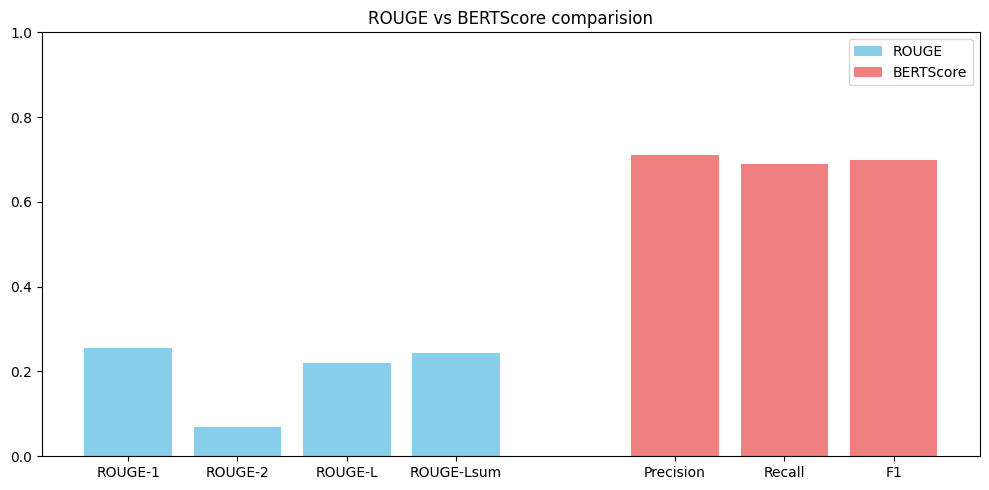

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# ROUGE 점수
rouge_scores = {
    "ROUGE-1": 0.2543,
    "ROUGE-2": 0.0702,
    "ROUGE-L": 0.2197,
    "ROUGE-Lsum": 0.2428
}

# BERTScore 점수
bertscore = {
    "Precision": 0.7095,
    "Recall": 0.6887,
    "F1": 0.6990
}

# 데이터 준비
labels_rouge = list(rouge_scores.keys())
values_rouge = list(rouge_scores.values())

labels_bert = list(bertscore.keys())
values_bert = list(bertscore.values())

# 위치 설정
x_rouge = np.arange(len(labels_rouge))
x_bert = np.arange(len(labels_bert)) + len(labels_rouge) + 1  # 간격 띄우기

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x_rouge, values_rouge, color='skyblue', label='ROUGE')
bars2 = ax.bar(x_bert, values_bert, color='lightcoral', label='BERTScore')

# 축, 제목 등 설정
ax.set_xticks(np.concatenate([x_rouge, x_bert]))
ax.set_xticklabels(labels_rouge + labels_bert)
ax.set_ylim(0, 1)
ax.set_title("ROUGE vs BERTScore comparision")
ax.legend()

plt.tight_layout()
plt.show()